In [ ]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import shapely
from shapely.geometry import Point, LineString, Polygon
import pyproj
import math

In [ ]:
# defining a point based on coordinates in Berlin
point = (52.5200, 13.4050)

In [ ]:
# Download the OpenStreetMap data for Berlin and looking at bike routes
G = ox.graph_from_point(point, dist=500, network_type='bike')
G

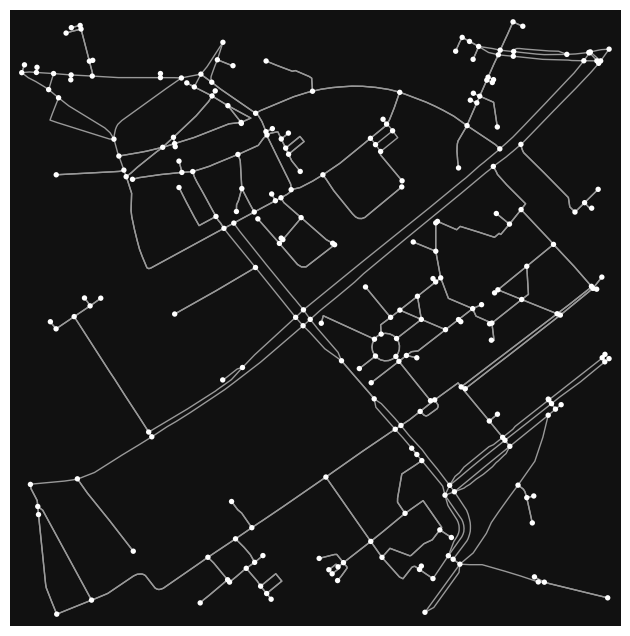

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [ ]:
# plot point
ox.plot_graph(G)

In [ ]:
# Convert the data into a NetworkX graph
NG = nx.Graph(G)

In [ ]:
# defining edge weights
edge_weight = 'edge_weight'
default_value = 0
edge_colour = 'edge_colour'
default_color = 'red'

In [ ]:
# applying edge attribute
nx.set_edge_attributes(G, default_value, name=edge_weight)
nx.set_edge_attributes(G, default_value, name=edge_colour)

In [ ]:
# defining coordinate to metre and metre to coordinate transformers
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 geographic coordinate system
target_crs = pyproj.CRS(proj= 'utm', zone=33)  # Spherical Mercator projection in meters

transformer_coord_2_metre = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

transformer_metre_2_coord = pyproj.Transformer.from_crs(target_crs, source_crs, always_xy=True)

lon = 13.4119613
lat = 52.5204791

x, y = transformer_coord_2_metre.transform(lon, lat)
print(f"X: {x:.2f} meters")
print(f"Y: {y:.2f} meters")

lon, lat = transformer_metre_2_coord.transform(x, y)
print(f"lon: {lon:.4f} degrees")
print(f"lat: {lat:.4f} degrees")

X: 392252.72 meters
Y: 5820115.03 meters
lon: 13.4120 degrees
lat: 52.5205 degrees


In [ ]:
# defining constant values for offset and width of each polygon (bounding box)
POLYGONOFFSET = 5
POLYGONWIDTH = 10

In [ ]:
# defining offset
def find_point_on_line(point1, point2, distance=POLYGONOFFSET):

    direction_vector = (point2[0] - point1[0], point2[1] - point1[1])

    direction_length = math.sqrt(direction_vector[0]**2 + direction_vector[1]**2)

    normalized_direction = (direction_vector[0] / direction_length, direction_vector[1] / direction_length)

    point_on_line = (point1[0] + normalized_direction[0] * distance, point1[1] + normalized_direction[1] * distance)

    return point_on_line

In [ ]:
# define polygon for street
def street_polygon(u, v, k):

  if 'geometry' in G.edges[(u, v, k)]:
    geometry = G.edges[(u, v, k)]['geometry']

  else:
    geometry = LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])

  list_geom = list(geometry.coords)
  list_lon = [coord[0] for coord in list_geom]
  list_lat = [coord[1] for coord in list_geom]
  list_x, list_y = transformer_coord_2_metre.transform(list_lon, list_lat)

  list_geom = list(zip(list_x, list_y))
  list_geom[0] = find_point_on_line(list_geom[0], list_geom[1])
  list_geom[-1] = find_point_on_line(list_geom[-1], list_geom[-2])

  list_geom = LineString(list_geom)
  transformed_polygon = list_geom.buffer(distance=POLYGONWIDTH, cap_style=3)

  list_geom = list(transformed_polygon.exterior.coords)
  list_x = [coord[0] for coord in list_geom]
  list_y = [coord[1] for coord in list_geom]

  list_lon, list_lat = transformer_metre_2_coord.transform(list_x, list_y)

  polygon = Polygon(list(zip(list_lon, list_lat)))

  print(geometry)
  print(polygon)

  return polygon

In [ ]:
# point is within street polygon
def is_in_street_polygon(point, polygon):

    is_contained = polygon.contains(Point(point['x'], point['y']))

    return is_contained

In [ ]:
# defining the weight of each edge based on classifier
def weight_edge(street_point_list):

    # TODO: define the value for the street
    return len(street_point_list)

In [ ]:
# defining specific colour for each weight
def lookup_colour(weight):

  # TODO: define color_lookup
  if weight < 1:
    clr = 'yellow'
  else:
    clr = 'blue'
  return clr

In [ ]:
# simplifying IDs for nodes
node_id_list = list(G.nodes)
id_1 = G.nodes[node_id_list[0]]
id_2 = G.nodes[node_id_list[1]]
id_3 = G.nodes[node_id_list[2]]

In [ ]:
# dictionary of IDs
d = {'id_1':id_1, 'id_2':id_2, 'id_3':id_3}

In [ ]:
# creating an ID in the dictionary for every node
d = dict()
node_id_list = list(G.nodes)
for i in range(10):
  d['id_' + str(i)] = G.nodes[node_id_list[i]]

In [ ]:
# creating a polygon based on node coordinates
poly = LineString([(id_1['x'], id_1['y']), (id_2['x'], id_2['y'])])

In [ ]:
# calling all functions

i = 0

for u, v, k in G.edges(keys=True):
  i += 1
  if i > 4:
    break

  polygon = street_polygon(u, v, k)
  street_point_list = []

  for _, point in d.items():

    if is_in_street_polygon(point, polygon):
      street_point_list.append(point)

  w = weight_edge(street_point_list)
  print(w)

  G.edges[(u, v, k)][edge_weight] = w
  G.edges[(u, v, k)][edge_colour] = lookup_colour(w)

LINESTRING (13.407195 52.5234208, 13.4071605 52.5233662, 13.407062 52.5231924, 13.4069855 52.5230745, 13.4069358 52.523, 13.4068707 52.5229435)
POLYGON ((13.40729893809681 52.52333534313678, 13.40720128118326 52.52316303169484, 13.40719902687824 52.52315932070374, 13.40712252656498 52.52304142078923, 13.40712199997654 52.52304062046606, 13.40707229978135 52.52296612052145, 13.40706516065854 52.52295694216032, 13.40705636922894 52.52294831377333, 13.40703363754725 52.52292858511579, 13.40694890081882 52.5228550425465, 13.40670776234704 52.52295841465892, 13.40680560762221 52.5230433344489, 13.40684873337696 52.5231079799827, 13.40692377879448 52.52322363877591, 13.4070212181449 52.52339556825088, 13.40702299024347 52.52339852621062, 13.40703099129143 52.52341118881436, 13.40708398895144 52.52349506367838, 13.40735900878499 52.52343041095887, 13.40729893809681 52.52333534313678))
POLYGON ((13.40617685774458 52.52366541810259, 13.40620679359064 52.52371155452416, 13.40629050644377 52.5238